In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import itertools
import math
import networkx as nx
from collections import Counter
from itertools import chain

In [2]:
df = pd.read_csv('GSE64881_segmentation_at_30000bp.passqc.multibam.txt', delimiter="\t")

In [3]:
df_hist1 = df[(df["chrom"]=="chr13") & (df["start"]>=21.69*10**6) & (df["stop"]<=24.12*10**6)]
#df_hist1

In [4]:
df_hist1_atleast1np = df_hist1[[col for col in df_hist1.columns[3:] if df_hist1[col].sum() >= 1]]
#df_hist1_atleast1np

In [5]:
def func(d):
    if d<0:
        return min(f_a*f_b, (1-f_a)*(1-f_b))
    elif d>0:
        return min(f_a*(1-f_b), f_b*(1-f_a))
    else:
        return 1

normalized_linkage_list = []
for row1,row2 in itertools.combinations(df_hist1_atleast1np.iterrows(), 2):
    f_a = row1[1].sum()/163
    f_b = row2[1].sum()/163
    f_ab = np.sum((row1[1]==1) & (row2[1]==1))/163
    
    d = f_ab - (f_a*f_b)
    
    d_max = func(d)

    normalized_linkage = d/d_max

    normalized_linkage_list.append(normalized_linkage)
#len(normalized_linkage_list)

In [6]:
# number of entries in upper triangular matrix (main diagonal excluded) is n(n-1)/2 = 3240 -> n=81

In [7]:
80*81/2

3240.0

In [8]:
n = 81
matrix = np.zeros((n,n))
upper_indx = np.triu_indices(n,k=1)
matrix[upper_indx]= normalized_linkage_list
matrix = (matrix >= (sum(normalized_linkage_list)/len(normalized_linkage_list)))
true_indices = np.where(matrix)
edges = list(zip(true_indices[0], true_indices[1]))
#len(edges)

In [9]:
#G = nx.Graph()
#G.add_edges_from(edges)

# Draw the graph
#plt.figure(figsize=(100, 100))
#nx.draw(G, with_labels=True, node_color='lightblue', node_size=400, font_size=20, font_weight='bold')
#plt.title("Graph Visualization")
#plt.savefig("network.png", format="png")
#plt.show()

In [10]:
def compute_degree_centrality(edges):
    #Create a dictionary to hold degree count for each node
    degree_count = {}
    for edge in edges:
        for node in edge:
            if node in degree_count:
                degree_count[node] += 1
            else:
                degree_count[node] = 1

    # Calculate the maximum possible degree
    max_possible_degree = len(degree_count)

    # Compute centrality by dividing degree by max_possible_degree
    centrality = {node: degree / max_possible_degree for node, degree in degree_count.items()}

    return centrality
#len(compute_degree_centrality(edges))

In [11]:
df_degree_centrality = pd.DataFrame.from_dict(compute_degree_centrality(edges), orient='index', columns=['Value'])

# Reset index to make the keys a column
df_degree_centrality.reset_index(inplace=True)

# Rename columns to more descriptive names
df_degree_centrality.columns = ['Index of window', 'Degree centrality']
df_degree_centrality.sort_values(by="Degree centrality", ascending=False)

Index of window  Degree centrality
49               37             0.7375
39               56             0.7375
33               35             0.7125
32               32             0.7125
14               39             0.7125
..              ...                ...
2                 2             0.1875
28               79             0.1625
79               76             0.1625
3                 3             0.1125
6                 6             0.0875

[80 rows x 2 columns]

In [12]:
# 44 is missing

In [13]:
community_dictionary = {
    "community_1" : [],
    "community_2" : [],
    "community_3" : [],
    "community_4" : [],
    "community_5" : [],
}


#hub_list = [37,56,35,32,39]
hub_list = list(df_degree_centrality.sort_values(by="Degree centrality", ascending=False)['Index of window'].head(5).values)

def community_finder(hub, edges):
    community_members = []
    for i, v in edges:
        if hub in [i, v]: 
            if (i, v) in edges:
                community_members.append((i, v))
            elif (v, i) in edges:  
                community_members.append((v, i))
    return community_members

for hub, community_number in zip(hub_list, community_dictionary.keys()):
    community_dictionary[community_number] = community_finder(hub,edges)


In [14]:
# create a edge dictionary, keys are all nodes, values are all edges having the node
all_nodes = list(df_degree_centrality['Index of window'])
edges_dict = {}

for node in all_nodes:
    edges_dict[node] = community_finder(node,edges)

In [15]:
#community_dictionary

In [16]:
# Size of the community
for key in community_dictionary.keys():
    print(f"Size of community {key[-1]} is")
    print(len(community_dictionary[key]))

Size of community 1 is
59
Size of community 2 is
59
Size of community 3 is
57
Size of community 4 is
57
Size of community 5 is
57


In [17]:
# Percentage of nodes that contain LAD and hist 1 gene
# first make a dict to store unique nodes in each community
nodes_dict = {
    "community_1": [],
    "community_2": [],
    "community_3": [],
    "community_4": [],
    "community_5": [],
}
for i in community_dictionary.keys():
    nodes_dict[i] = list(set(itertools.chain(*community_dictionary[i])))
    
# nodes in each community
#nodes_dict

In [18]:
#nodes_dict
# second from feature df find nodes that are LAD and Hist 1
features_dict = {
    "lad": [],
    "hist1": [],
}

In [19]:
feature_df = pd.read_csv("xid-280141502_1.csv")
feature_df = feature_df[["LAD", "Hist1"]]
feature_df.index = df_hist1_atleast1np.index

In [20]:
feature_df["index"] = list(range(0,81))
#feature_df

In [21]:
# Third find the index of nodes in hist1 and lad
features_dict["lad"] = list(feature_df[feature_df["LAD"]==1]["index"].values)
features_dict["hist1"] = list(feature_df[feature_df["Hist1"]==1]["index"].values)

In [22]:
# Fourth find the commons b/w nodes in each community and lad and hist1 nodes
lad_commons = {}
for key in nodes_dict.keys():
    lad_commons[key]= set(features_dict["lad"]) & set(nodes_dict[key])

hist1_commons = {}
for key in nodes_dict.keys():
    hist1_commons[key]= set(features_dict["hist1"]) & set(nodes_dict[key])
    
#lad_commons = {
    #"community_1": set(features_dict["lad"]) & set(nodes_dict["community_1"]) ,
    #"community_2": set(features_dict["lad"]) & set(nodes_dict["community_2"]),
    #"community_3": set(features_dict["lad"]) & set(nodes_dict["community_3"]),
    #"community_4": set(features_dict["lad"]) & set(nodes_dict["community_4"]),
    #"community_5": set(features_dict["lad"]) & set(nodes_dict["community_5"]),
#}
#hist1_commons = {
    #"community_1": set(features_dict["hist1"]) & set(nodes_dict["community_1"]),
    #"community_2": set(features_dict["hist1"]) & set(nodes_dict["community_2"]),
    #"community_3": set(features_dict["hist1"]) & set(nodes_dict["community_3"]),
    #"community_4": set(features_dict["hist1"]) & set(nodes_dict["community_4"]),
    #"community_5": set(features_dict["hist1"]) & set(nodes_dict["community_5"]),
#}


In [23]:
# Calculate the precentage for each community and for lad and hist1
for key in nodes_dict.keys():
    print(key)
    print(round(len(lad_commons[key])/len(nodes_dict[key]), 2))
    print(round(len(hist1_commons[key])/len(nodes_dict[key]),2))

community_1
0.58
0.08
community_2
0.58
0.13
community_3
0.6
0.1
community_4
0.6
0.05
community_5
0.6
0.1


In [24]:
# interaction type 1 -> hub in center connected to all edges
# interaction type 2 -> all connections within a community 
def visualizer(edges, community_name, interaction_type):
    if interaction_type==1:
        G = nx.Graph()
        for node in nodes_dict[community_name]:
            G.add_node(node)
        G.add_edges_from(community_dictionary[community_name])
        node_sizes = [compute_degree_centrality(edges)[node] * 1000 for node in G.nodes()]

        # Draw the network
        pos = nx.spring_layout(G)  # positions for all nodes

        fig, ax = plt.subplots(figsize=(8, 8))
        nx.draw(G, pos, with_labels=True, node_size=node_sizes, edge_color='gray', linewidths=2,
                node_color='lightblue', alpha=0.6, font_size=15)

        plt.title(f"Network of Genomic Interactions between hub node and other nodes in community {community_name[-1]}")
        plt.show()
    if interaction_type==2:
        G = nx.Graph()
        for node in nodes_dict[community_name]:
            G.add_node(node)
            G.add_edges_from(edges_dict[node])
        node_sizes = [compute_degree_centrality(edges)[node] * 1000 for node in G.nodes()]

        # Draw the network
        pos = nx.spring_layout(G)  # positions for all nodes

        fig, ax = plt.subplots(figsize=(15, 15))
        nx.draw(G, pos, with_labels=True, node_size=node_sizes, edge_color='gray', linewidths=2,
                node_color='lightblue', alpha=0.6, font_size=15)

        plt.title(f"Network of Genomic Interactions in community {community_name[-1]} ")
        plt.show()

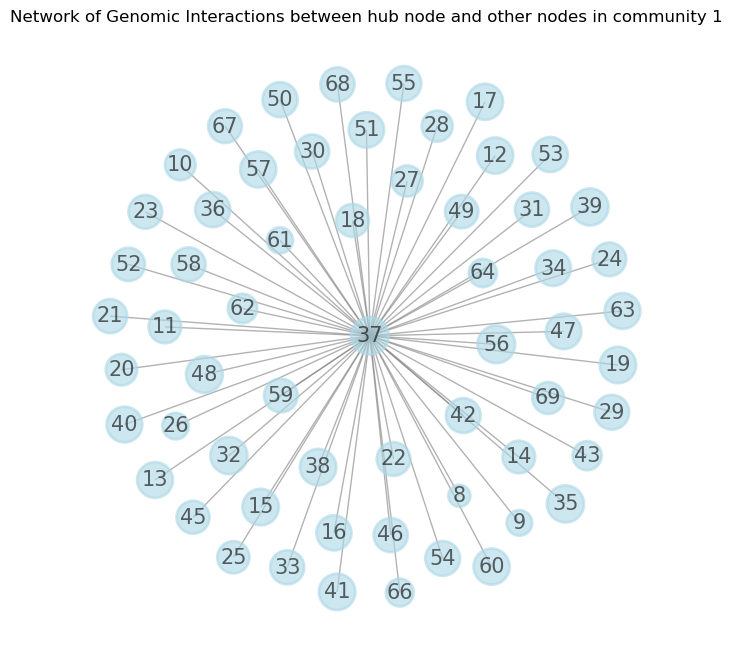

In [25]:
visualizer(edges=edges, community_name="community_1", interaction_type=1)

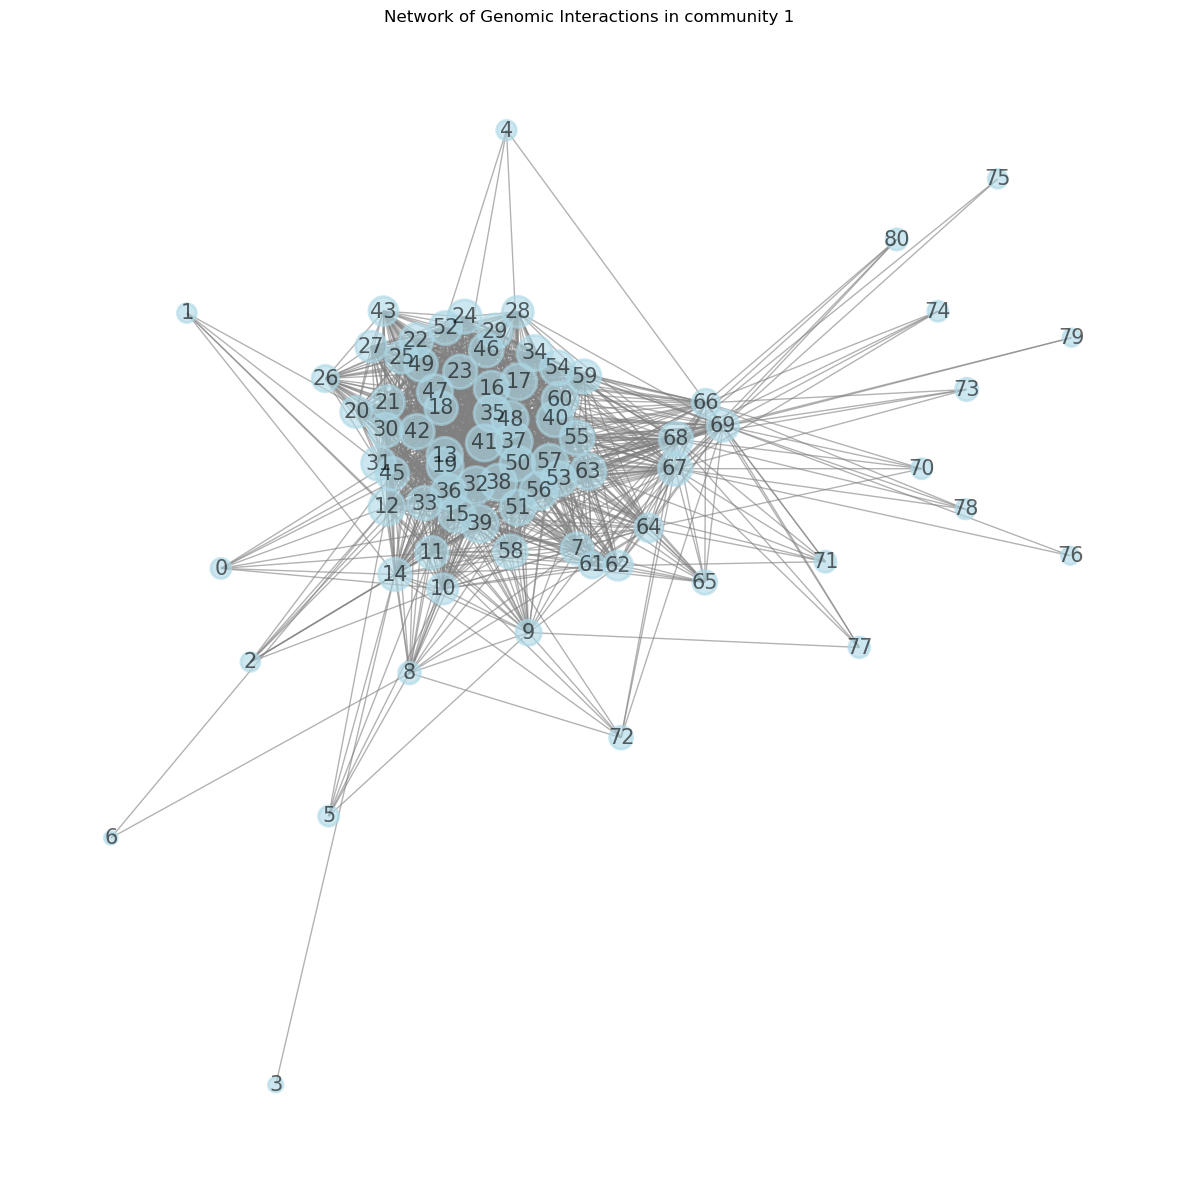

In [26]:
visualizer(edges=edges, community_name="community_1", interaction_type=2)

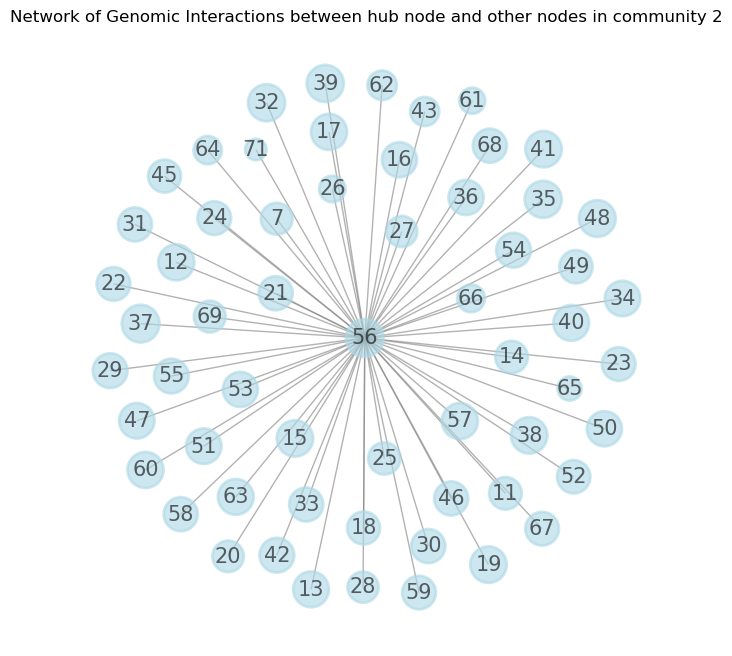

In [27]:
visualizer(edges=edges, community_name="community_2", interaction_type=1)

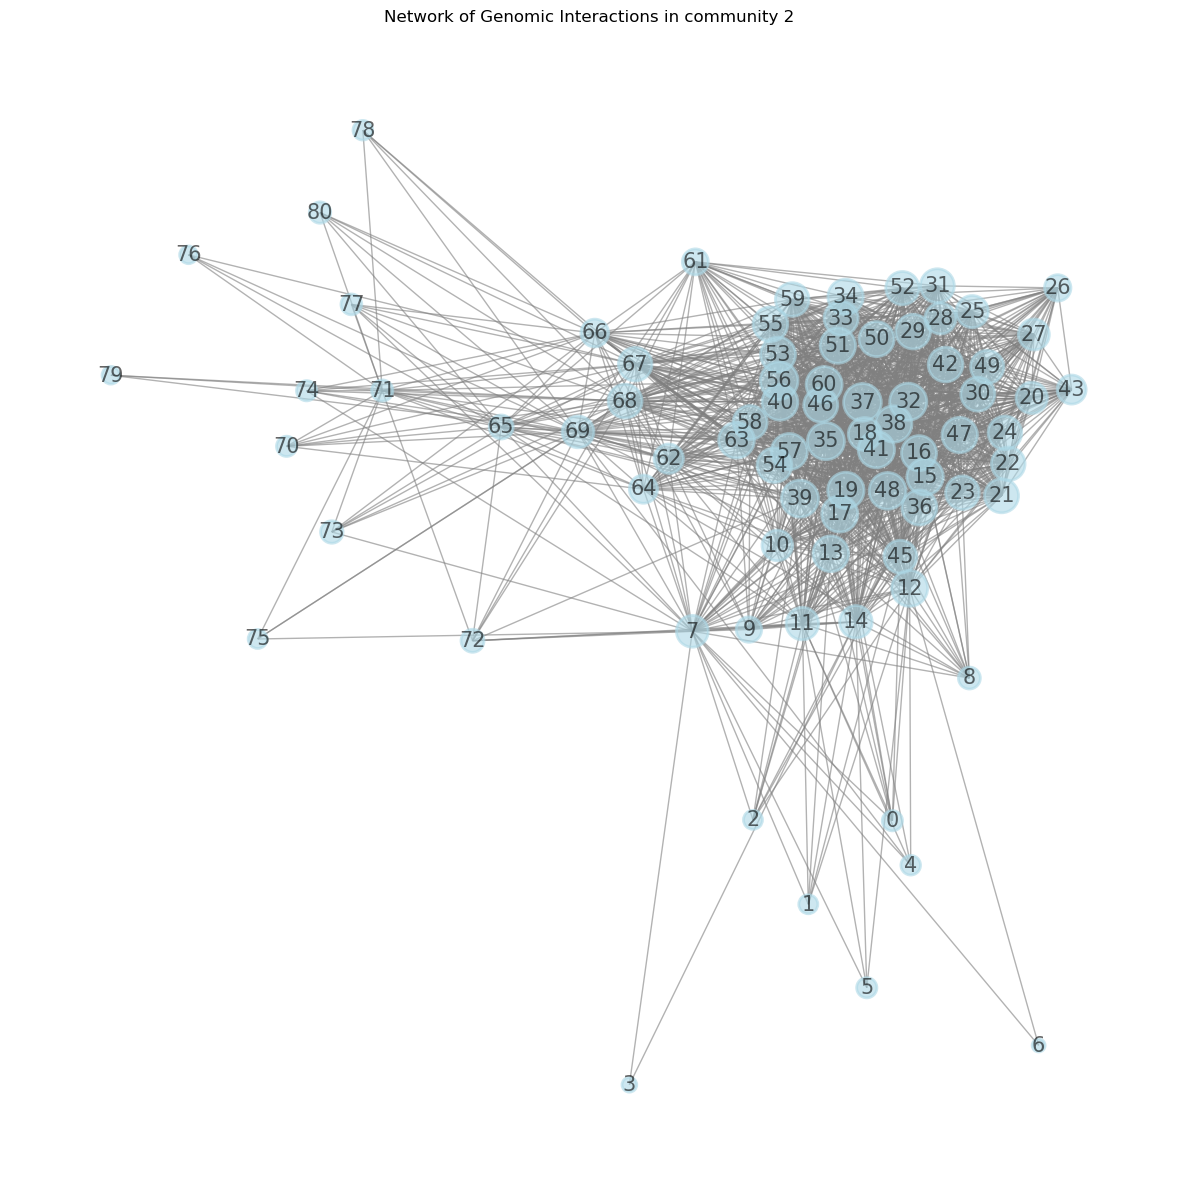

In [28]:
visualizer(edges=edges, community_name="community_2", interaction_type=2)

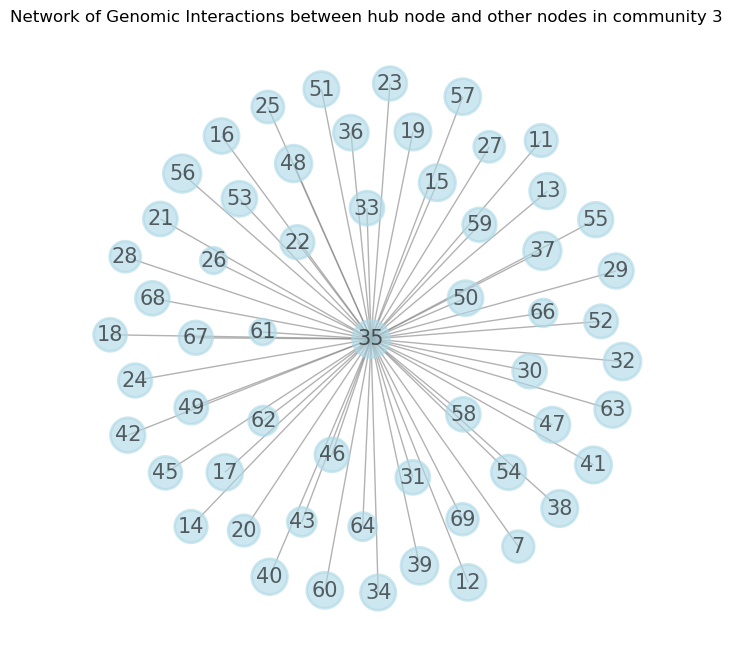

In [29]:
visualizer(edges=edges, community_name="community_3", interaction_type=1)

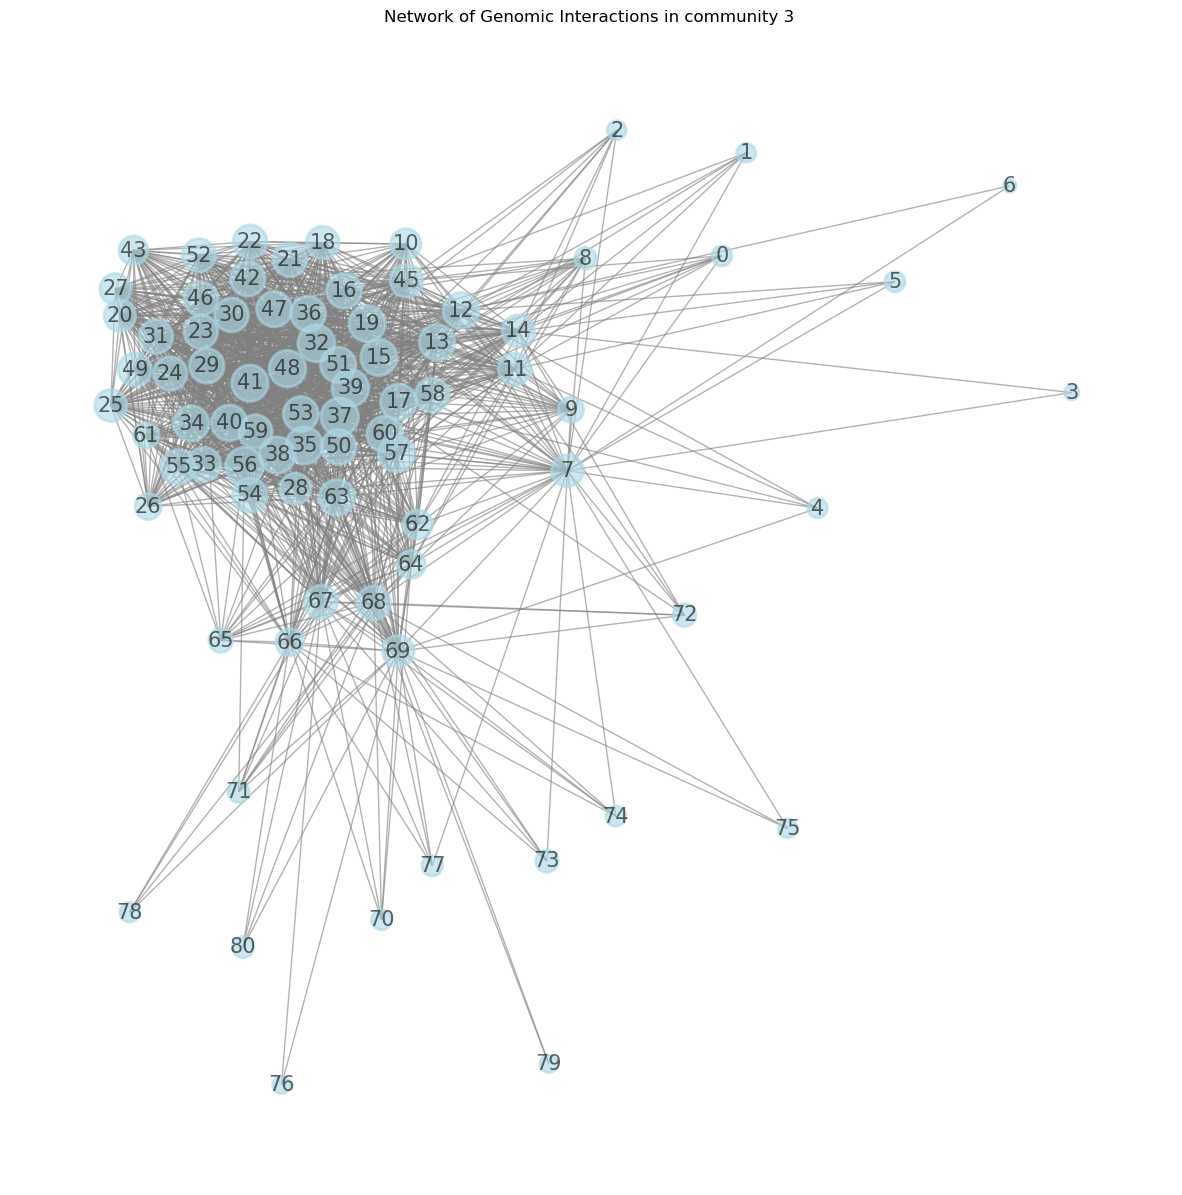

In [30]:
visualizer(edges=edges, community_name="community_3", interaction_type=2)

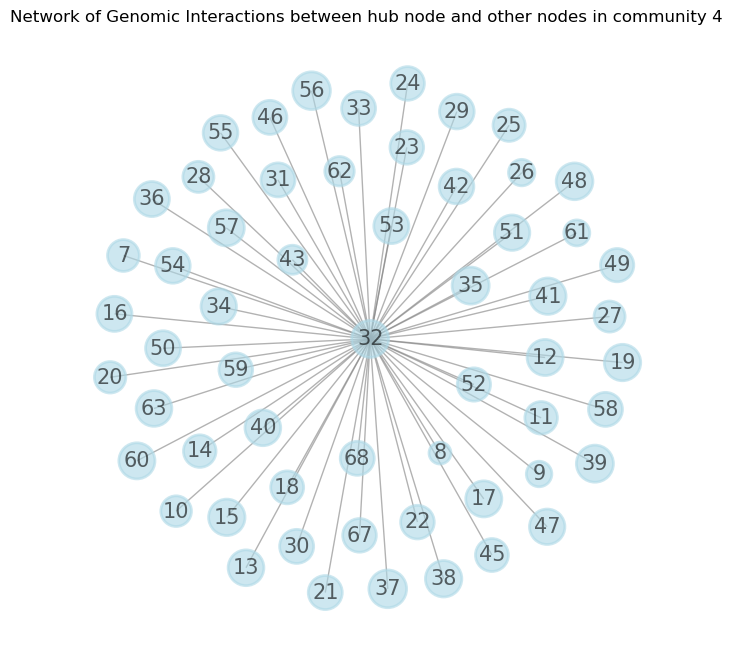

In [31]:
visualizer(edges=edges, community_name="community_4", interaction_type=1)

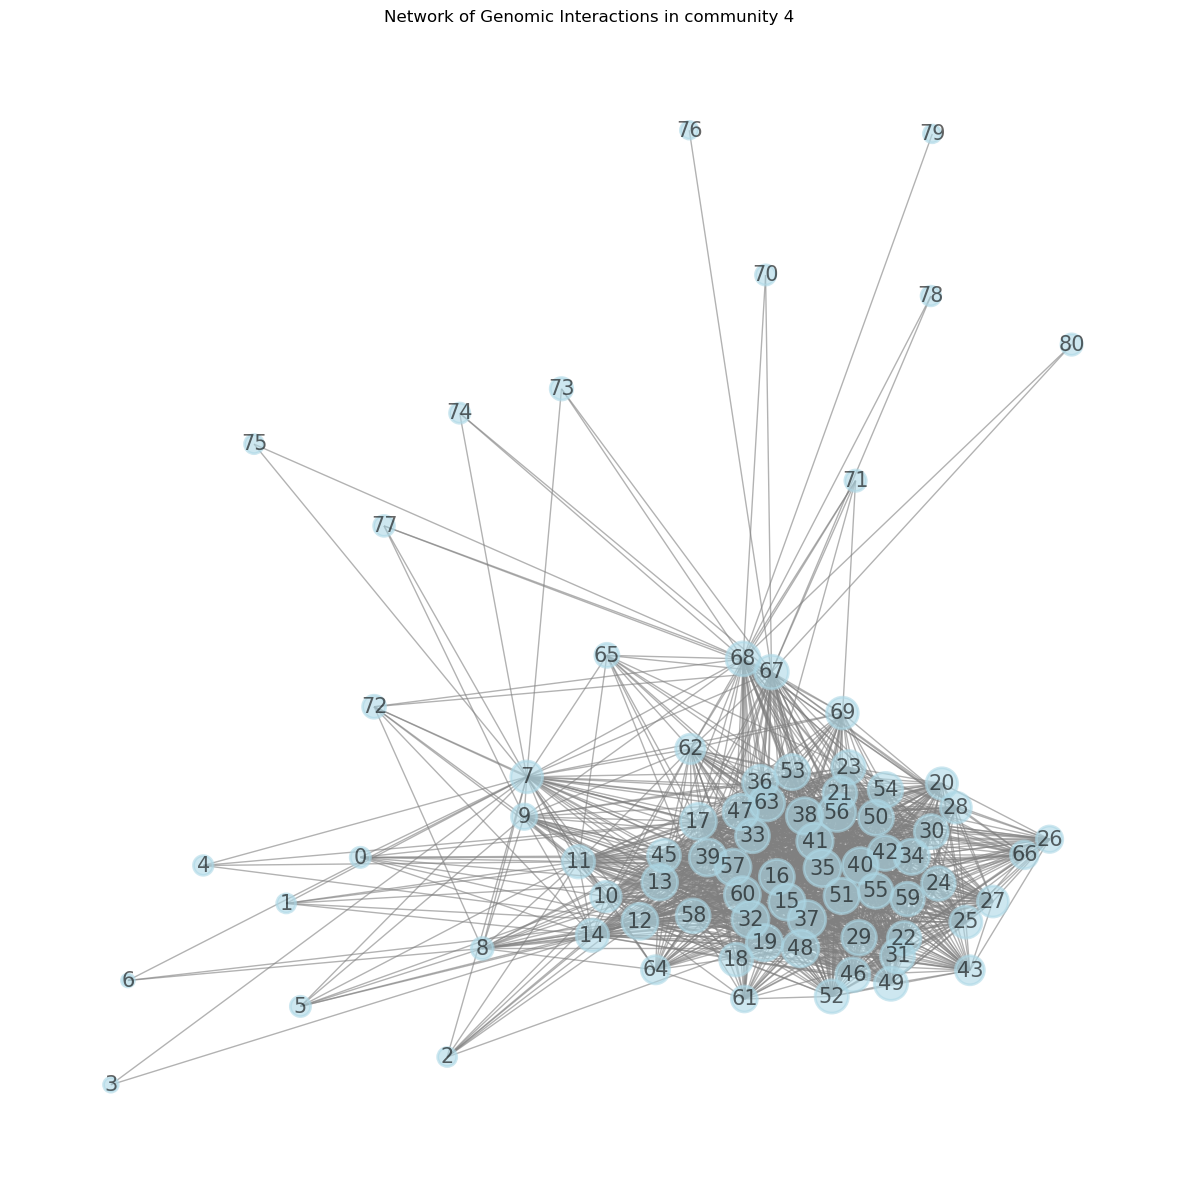

In [32]:
visualizer(edges=edges, community_name="community_4", interaction_type=2)

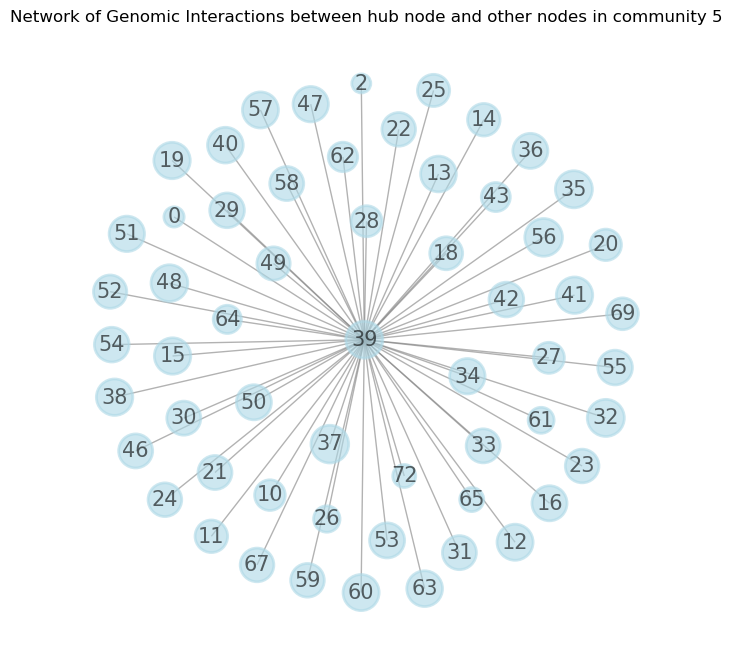

In [33]:
visualizer(edges=edges, community_name="community_5", interaction_type=1)

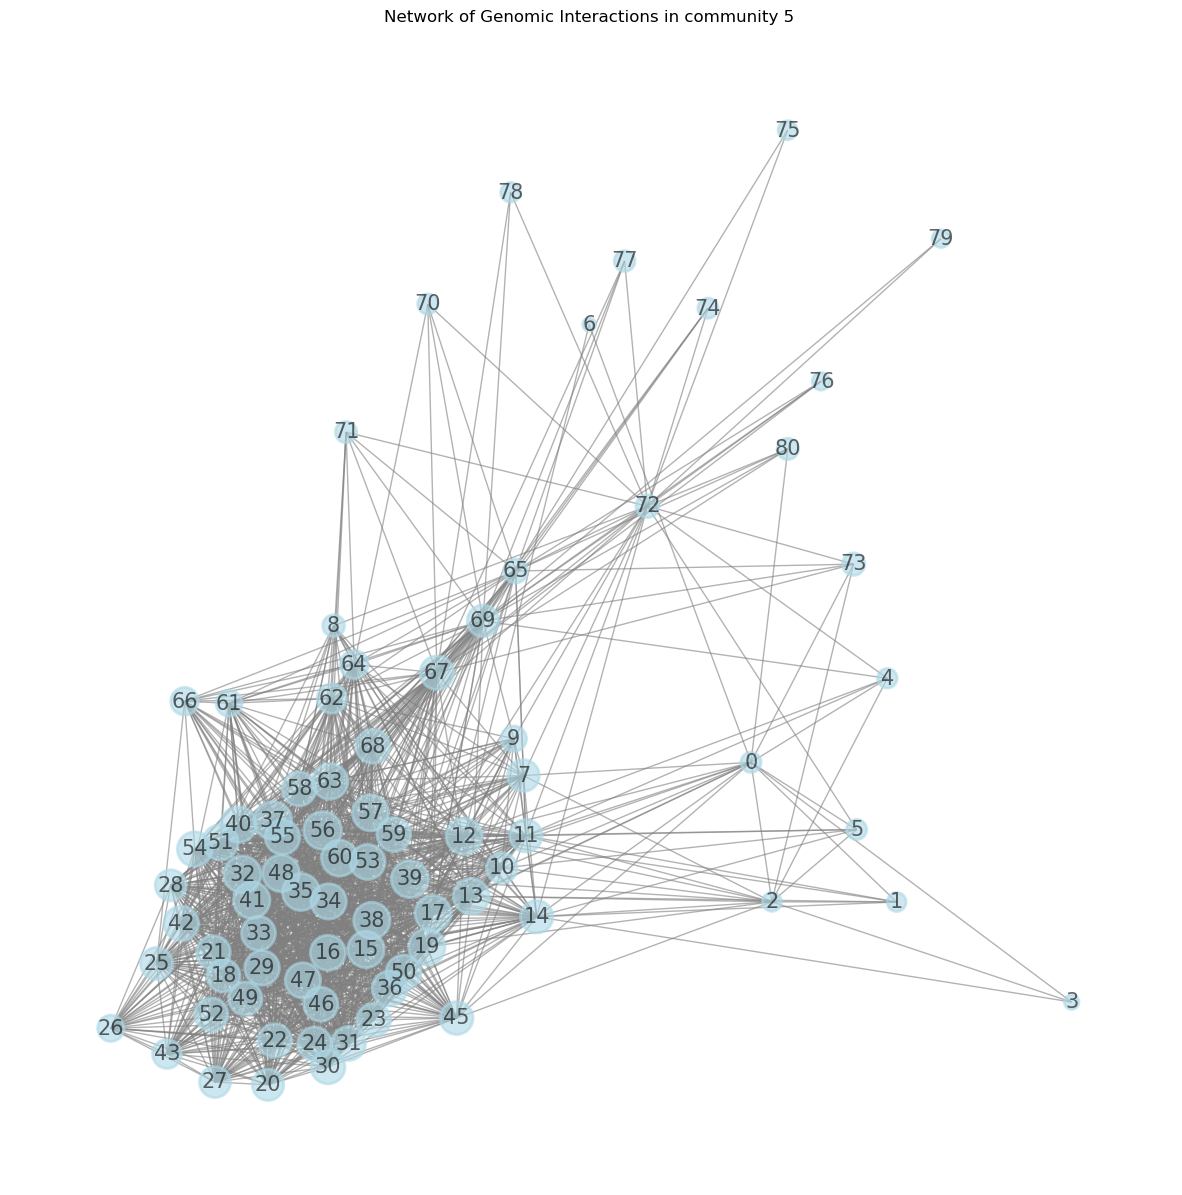

In [34]:
visualizer(edges=edges, community_name="community_5", interaction_type=2)

In [35]:
def heatmap(community_name):
    size = 81
    mat = np.zeros((size,size))
    indices = []
    for node in nodes_dict[community_name]:
        indices.append(edges_dict[node])
        
    flat_indices = list(chain.from_iterable(indices)) 
    #print(len(flat_indices))
    #print(set(flat_indices))
    for row,col in list(set(flat_indices)):
        mat[row,col]=1
    for row,col in list(set(flat_indices)):
        mat[col,row]=1
    sns.heatmap(mat, cmap="viridis")  
    plt.title(f'Heatmap of community {community_name[-1]}')
    plt.xlabel('Windows')
    plt.ylabel('Windows')
    plt.show()

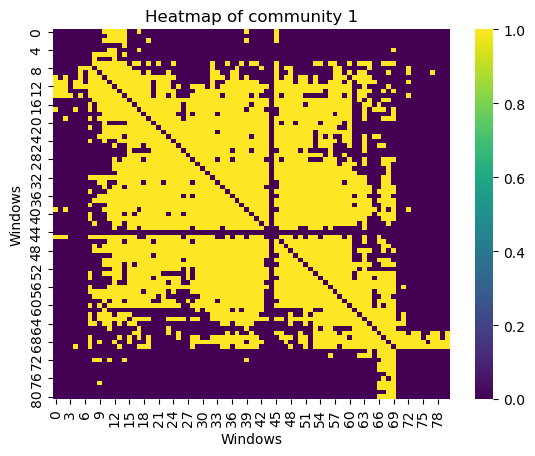

In [36]:
heatmap("community_1")

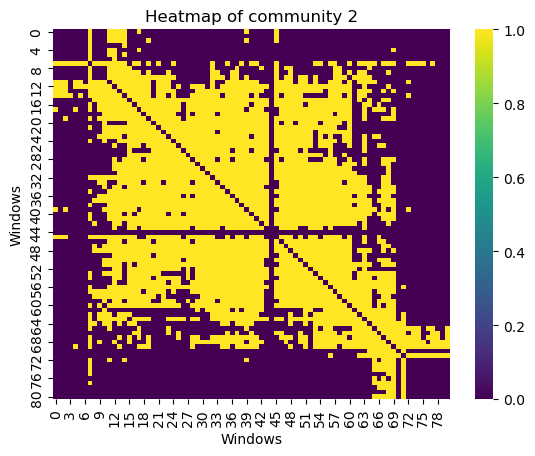

In [37]:
heatmap("community_2" )

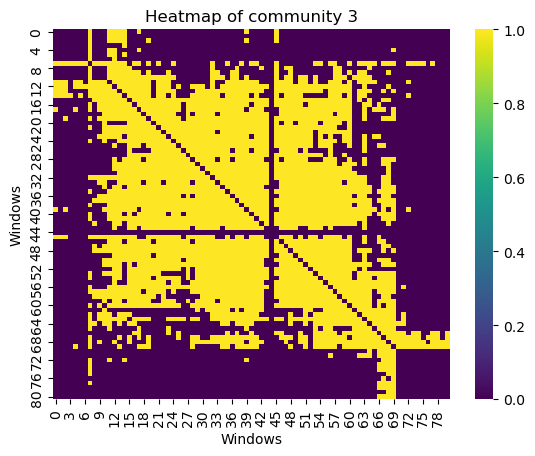

In [38]:
heatmap("community_3" )

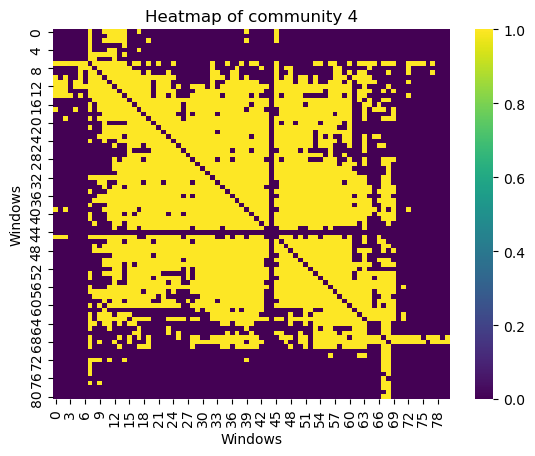

In [39]:
heatmap("community_4" )

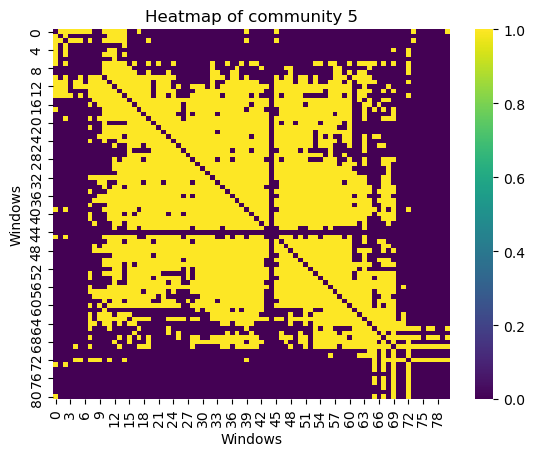

In [40]:
heatmap("community_5" )